In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

ModuleNotFoundError: No module named 'sklearn'

In [3]:
mnist.DESCR

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

It's because each picture is 28 * 28 dimension so there are 70k image and each feature is a pixel which has a value from 0 to 255.

label 5


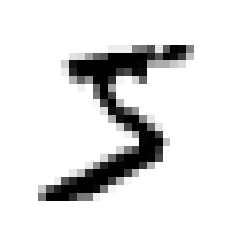

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = X[0]

some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
print("label", y[0])
plt.show()

In [8]:
y = y.astype(np.uint8)

# Split train test!

the MNIST dataset is already split into train / test set: the first 60k images are train and the rest is for test usage.

In [9]:
X_train, y_train, X_tet, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

# Training a binary classifier

First of all, let's try to train a digit 5 binary classifier: it will be able to predict if it 5 or not 5.

In [10]:
y_train_5 = (y_train == 5) # True when label is 5 else False
y_test_5 = (y_test == 5)

In [11]:
unique, counts = np.unique(y_train_5, return_counts=True)
dict(zip(unique,counts))

{False: 54579, True: 5421}

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measure

## Implementing your own Cross-Validation

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone 

skfolds = StratifiedKFold(n_splits=3,random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

/Users/solalperso/ml/my_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.8787
0.8495
0.85815


In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow this looks great! Around 96% accuracy! But before getting excited, let's look at the performance of a classifier that always predict not 5 class.

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train,y_train_5, cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Wow! Around 90% accuracy :o. That's simply because only 10% of the dataset pictures are 5.  
This shows why accuracy is not the prefered performance measure, specially when the data are skewed. 

## Confusion Matrix

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function `cross_val_predict` performs K fold cv but instead of returning each scores, it returns the predictions made on each fold. This means that you get a clean prediciton for each instance ine the training set.

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

## Precision and Recall

In [20]:
from sklearn.metrics import precision_score, recall_score

In [21]:
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

Scikit learn does not let you set the threshold directly but it doe sgive you access to the decision scores that it uses to make predictions.  
Instead of calling the predict() method, you can call the decision_function().

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold = 0 
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The SGDClassifier use the threshold equal to 0. So the previous didnt change the default prediciton. 

In [26]:
threshold = 8000 
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

## How do you decide which threshold to use?

First you gonna use the cross_val_predict() function but this time specify that you want to return decision scores instead of predicitions.

In [27]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

In [28]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

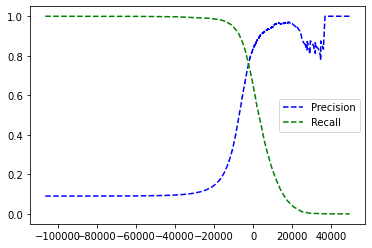

In [29]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.legend()

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

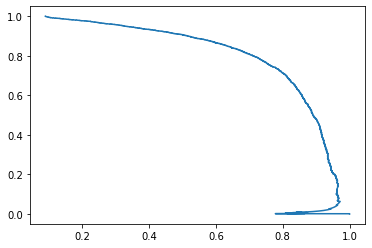

In [30]:
plt.plot(precisions,recalls)

Suppose you decide to aim at least 90% precision, to find the threshold you should do:

In [31]:
threshold_90_precision = thresholds[np.argmax(precisions > 0.9)]
threshold_90_precision

3370.0194991439557

In [32]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [33]:
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [34]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [35]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Note: If someone says "Let's reach 90% precision", you should ask "At what recall?"

## The ROC Curve?

The Reciever Operating Characteristic curve plots the TPR (also recall) against the FPR.  
FPR == 1 - TPR (which is the ratio of the negative instances that are correctly classified as negative, also called specificity).  
FPR = ratio of the negative instance that are badly classified as positive.
Its sensitivity vs 1 - specificity

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, thresolds = roc_curve(y_train_5, y_scores)

No handles with labels found to put in legend.


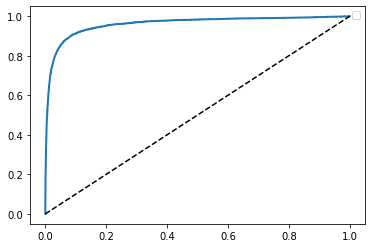

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--') # dashed diagonal
    plt.legend()

plot_roc_curve(fpr,tpr)
plt.show()

In [38]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Important note:**  
Since the ROC Curve is so similar to the precision/recall curve, you may wonder how to decide which one to use.   
As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives.  
Otherwise, use the RROC curve. For example, looking at the the previous ROC curve, (and the auc score), you may think that the classifier is really good, .  
But this is mostly becaause there are few positives (5s) compared to the negatives (non 5-s). In contrast, the PR curve makes it clear that  
the classifier has room for improvement (the curve coulb be closer to the top-left corner). 

## Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

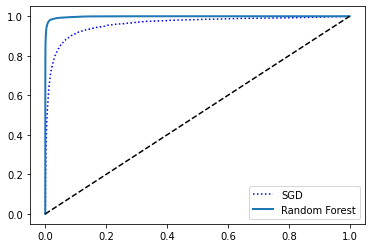

In [40]:
y_probas_forest_scores = y_probas_forest[:,1] # get the proba of being positive as score
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_probas_forest_scores)
plt.plot(fpr, tpr, 'b:', label='SGD') # plot SGD Classifier curve
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.show()

In [41]:
roc_auc_score(y_train_5, y_probas_forest_scores)

0.9983436731328145

In [42]:
y_forest_05_threshold = (y_probas_forest_scores >= 0.5)

print("Pecision", precision_score(y_train_5, y_forest_05_threshold))
print("Recall", recall_score(y_train_5, y_forest_05_threshold))

Pecision 0.9897468089558485
Recall 0.8725327430363402


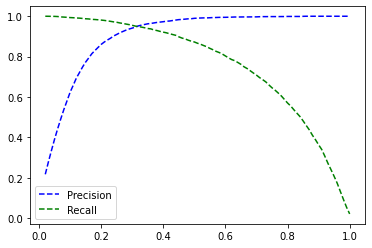

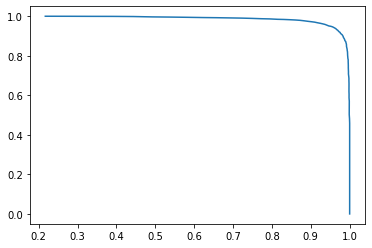

In [43]:
precisions_forest, recall_forest, threshold_forest = precision_recall_curve(y_train_5, y_probas_forest_scores)
plot_precision_recall_vs_threshold(precisions_forest, recall_forest, threshold_forest)
plt.show()
plt.plot(precisions_forest, recall_forest)

## Multiclass classification

SGDClassifier & RandomForest are both able to classify between multiples classes. However, that's not the case for all classifiers such as 
LogisticRegression or SVM) are native binary classifiers. Hopefully there exist some strategy to perform multiclass classifiication using 
binary classifiers. You train 10 binary classifiers (one for each digit) and you take the highest prediction score to classifiy your new image. That's called the *one-versus-the-rest strategy or one-versus-all*. 

Another strategy is to train a classifier for each pair of digits, so you need to train N * (N - 1) / 2 classifiers, that's equal to 43 in our situation! The main advantage of the *one vs one* strategy is that each classifier only needs to be trained on the part of the training 
set for the two class that is must distinguish.

Some algorithm (such as SVM) scale poorly with the size of the training set. For these algorithms OvO iss prefered.  
For most binary classifications algorithm, OvR is preferred.

Scikit-learn detects automatically when you run a binary classifier for MC and it runs OvR or OvO depending on the algorithm.

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores